# Problem 1: counting parameters (30%):
## Count the parameters for the following three network configurations. 
## Please show & clearly explain how you arrive at the numbers (not just use count_params())

In [ ]:
MAX_SEQ_LEN = 512
MAX_WORDS = 50000
EMBEDDING_DIM = 50

In [ ]:
# Network 1
word_input = Input(
    shape=(MAX_SEQ_LEN,), 
    dtype='int32'
)
hidden_state = Embedding(
    MAX_WORDS, 
    EMBEDDING_DIM, 
    input_length=MAX_SEQ_LEN
)(word_input)
hidden_state = LSTM(
    64, dropout=0.2)(hidden_state)
hidden_state = Dense(32)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(10, activation='softmax')(hidden_state)
model = Model(word_input, output)
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()
model.count_params()

## [50000 * 50] + [() + ] + [(64 * 32) + 32] + [(32 * 10) + 10]|

In [ ]:
# Network 2
word_input = Input(
    shape=(MAX_SEQ_LEN,), 
    dtype='int32'
)
hidden_state = Embedding(
    MAX_WORDS, 
    EMBEDDING_DIM, 
    input_length=MAX_SEQ_LEN
)(word_input)

hidden_state = SimpleRNN(
    64, 
    return_sequences=True
)(hidden_state)

hidden_state = LSTM(
    64, 
    recurrent_dropout=0.2
)(hidden_state)

output = Dense(1, activation='sigmoid')(hidden_state)
model = Model(word_input, output)
model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.count_params()

In [ ]:
# Network 3
word_input = Input(
    shape=(MAX_SEQ_LEN,), 
    dtype='int32'
)
hidden_state = Embedding(
    MAX_WORDS, 
    EMBEDDING_DIM, 
    input_length=MAX_SEQ_LEN
)(word_input)

hidden_state = LSTM(
    64, 
    return_sequences=True
)(hidden_state)

hidden_state = LSTM(
    64, 
    return_sequences=True
)(hidden_state)


hidden_state = Bidirectional(LSTM(
    64, 
    recurrent_dropout=0.2
))(hidden_state)

output = Dense(1, activation='sigmoid')(hidden_state)

model = Model(word_input, output)
model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.count_params()

# Problem 2: Many Ways to Solve the Same Problem (35%)
### ... and the limits of deep learning...

## We saw three ways to solve the IMDB problem:
 - flatten the sequence and send to a dense network
 - a (bidirectional) LSTM to get sequence information
 - being "clever" with the features we use (FastText)
 

# We want to try to combine these 


## Part 0: Prep

In [ ]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(
    abs(hash('mit') // (2 ** 32 -1))
)

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

from keras.layers import (
    SimpleRNN, Dense, LSTM,
    Embedding, Input, Dropout,
    Concatenate
)
from keras.models import Model
import keras.backend as K


In [17]:
INDEX_FROM = 3   # word index offset
MAX_WORDS = 50000
MAX_SEQ_LEN = 500
EMBEDDING_DIM = 50
NUM_HIDDEN_RNN = 64


((int_sequences_train, y_train), 
 (int_sequences_test, y_test)) = imdb.load_data(
    num_words=MAX_WORDS, 
    index_from=INDEX_FROM
)

# Some word magic
word_to_id = imdb.get_word_index()
word_to_id = {k:(v + INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}




((int_sequences_train, y_train), 
 (int_sequences_test, y_test)) = imdb.load_data(
    num_words=MAX_WORDS
)

NameError: name 'imdb' is not defined

In [ ]:
GLOVE_FILE = '/Users/Hugo/Documents/data/text/glove.6B/glove.6B.50d.txt'  # FIXME 

In [ ]:
def load_glove_file(filepath):
    word_to_vector = {}
    with open(filepath) as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vector[word] = vector
    return word_to_vector

word_vecs = load_glove_file(GLOVE_FILE)

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for  i, word in id_to_word.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Part 1: Solve the problem with the "Fasttext" method

In [ ]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indices, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indices:
                    new_list.append(token_indices[ngram])
        new_sequences.append(new_list)

    return new_sequences


In [ ]:
NGRAM_RANGE = 2
MAX_WORDS_FT = 5000

ft_sequences_train = int_sequences_train[:]  # makes a copy
ft_sequences_test = int_sequences_test[:]  # makes a copy

# TODO(filter ft_sequences to only elements that are less than MAX_WORDS_FT)
# YOUR CODE HERE

if NGRAM_RANGE > 1:
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in ft_sequences_train:
        for i in range(2, NGRAM_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = MAX_WORDS_FT + 1
    token_indices = {v: k + start_index for k, v in enumerate(ngram_set)}
    indices_token = {token_indices[k]: k for k in token_indices}

    # max_features is the highest integer that could be found in the dataset.
    MAX_FEATURES_FASTTEXT = np.max(list(indices_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    ft_sequences_train = add_ngram(ft_sequences_train, token_indices, NGRAM_RANGE)
    ft_sequences_test = add_ngram(ft_sequences_test, token_indices, NGRAM_RANGE)


In [ ]:
# TODO: pad the sequences
# YOUR CODE HERE
#ft_sequences_train ... 
...

In [ ]:
from keras.initializers import Constant
from keras.layers import Flatten, GlobalAveragePooling1D

In [ ]:
K.clear_session()

fastext_word_input = Input(
    shape=(MAX_SEQ_LEN,),
    dtype='int32'
)
# your code here, don't forget to compile the model

In [ ]:
# ~40s epoch
model.fit(
    ft_sequences_train,
    y_train, 
    epochs=8, 
    batch_size=128, 
    validation_split=0.2
)

In [ ]:
from sklearn.metrics import accuracy_score
pd.DataFrame(model.history.history)[['acc', 'val_acc']].plot(
    figsize=(16,9), fontsize=16, style='o', markersize=16
)
plt.legend(fontsize=16)
plt.xlabel('epoch', fontsize=16)


preds_ft = model.predict(ft_sequences_test).squeeze()
test_acc_ft = accuracy_score(y_test, (preds_ft > 0.5).astype(int))
plt.title('test accuracy = {:.3f}'.format(test_acc_ft), fontsize=20)

## Part 2: Solve the problem with an LSTM

In [ ]:
K.clear_session()

single_word_input = Input(shape=(MAX_SEQ_LEN,), 
                   dtype='int32')

# TODO: 
# make a non-trainable embedding
# make a single layer lstm
# make a single neuron dense layer

# your code here
# don't forget to compile the model

model.summary()

In [ ]:
# ~60s / epoch
model.fit(
    int_sequences_train,
    y_train, 
    epochs=10, 
    batch_size=128, 
    validation_split=0.2
)

In [ ]:
pd.DataFrame(model.history.history)[['acc', 'val_acc']].plot(
    figsize=(16,9), fontsize=16, style='o', markersize=16
)
plt.legend(fontsize=16)
plt.xlabel('epoch', fontsize=16)


preds_rnn = model.predict(int_sequences_test).squeeze()
test_acc_rnn = accuracy_score(y_test, (preds_rnn > 0.5).astype(int))
plt.title('test accuracy = {:.3f}'.format(test_acc_rnn), fontsize=20)

## Part 3: Solve the problem by flattening the sequence

In [ ]:
K.clear_session()

single_word_input = Input(shape=(MAX_SEQ_LEN,), 
                   dtype='int32')

# TODO
# make a non-trainable embedding
# flatten the sequence
# add some dorpout
# add a dense layer
# add dropout
# add a dense layer with one neuron

# your code here
# don't forget to compile the model

model.summary()

In [ ]:
model.fit(
    int_sequences_train,
    y_train, 
    epochs=8, 
    batch_size=128, 
    validation_split=0.2
)

In [ ]:
pd.DataFrame(model.history.history)[['acc', 'val_acc']].plot(
    figsize=(16,9), fontsize=16, style='o', markersize=16
)
plt.legend(fontsize=16)
plt.xlabel('epoch', fontsize=16)


preds_flat = model.predict(int_sequences_test).squeeze()
test_acc_flat = accuracy_score(y_test, (preds_flat > 0.5).astype(int))
plt.title('test accuracy = {:.3f}'.format(test_acc_flat), fontsize=20)

# Part 4: Bagging
## Improving with bagging
In ML there is a common technique to __bag__ multiple estimators togther. 

The basic idea is to reduce variance by average together multiple estimators that should have
different kinds of errors. 

NB: A random forest is a bagging estimator

### Learning weights
 - We can learn weights for the various estimators (we have enough data to do this).
 - We'll do it on the test data, which is technically cheating



In [ ]:
from sklearn.linear_model import LogisticRegression
# TODO
# - concatenate the test-set predictions from each method
#      it should be a lenght-of-test-data x 3 vector
# - fit a 3-feature logistic regression to the data
# - print the test_set accuacy

# your code here...

# lr = LogisticRegression( ...

# your code here...

print('new accuracy {:.3f}'.format(accuracy_score(y_test, new_preds)))

In [ ]:
# print the coefficients
# your code here...

### You can also just guess hard_coded weights based on performance

In [ ]:
wt_flat = 1
wt_rnn = 2
wt_ft = 12

total_wt = (wt_flat + wt_ft + wt_flat)

In [ ]:
# TODO
# - make a weighted average of all the predictions
# - calculate the test accuracy

# your code here

print('test accuracy = {:.4f}'.format(test_acc_voted))

# Part 5: combine them with neural nets
## Our goal is to construct a a neural network with two inputs and one output:
### Inputs
 - Embedded glove words, untrainable, for the RNN and the flattening
 - The fastext bigrams
### Output:
 - the usual `0/1` for the IMDB task
 
### Newtork: 
 - make a single LSTM on the word vectors
 - flatten the ORIGINAL word-vector sequence and have it go through a single dense layer
    - add dropout appropriately
 - average the fasttext input over all the words

This will make 3 different sets of features. You should
 - concatenate them
 - add some dropout
 - send the merged output to a single-neuron dense layer.
 
# $ \\ $
# Network
```
int-input-sequence   fastext-input sequence
     |                      |
 embedding                embedding
 (non-trainable)          (trainabile)
 |                           |
 |\                          |    
 | \                         |
 |  \                  Average over words
 |   \                       |
 |    \                      |
 |     \                     |
 Flatt  LSTM                 |
 |        |                  |
 Drop     |                 /
 |        |                /
 Dense    |               /
 |         \             /
 Drop       \           /
 |           \         /
 ######################
 ####### concat #######
 ######################
          |
         Drop
          |
        Dense(1)

```

In [ ]:
K.clear_session()
# Your code here
# don't forget to compile your model

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

plot_model_in_notebook(model)

In [ ]:
model.summary()

## This is a big model
### If you can fit it on your computer (probably needs 16GB RAM) then do so
### if not, try one epoch with a very small batch

In [ ]:
# ~2 min epoch
model.fit(
    [int_sequences_train, ft_sequences_train],
    y_train, 
    epochs=1, 
    batch_size=128, 
    validation_split=0.2
)

In [ ]:
from sklearn.metrics import accuracy_score
pd.DataFrame(model.history.history)[['acc', 'val_acc']].plot(
    figsize=(16,9), fontsize=16, style='o', markersize=16
)
plt.legend(fontsize=16)
plt.xlabel('epoch', fontsize=16)


preds = (model.predict([
    int_sequences_test, 
    ft_sequences_test
]) > 0.5).squeeze().astype(int)
test_acc = accuracy_score(y_test, preds)
plt.title('test accuracy = {:.3f}'.format(test_acc), fontsize=20)

## The crux of the problem!
## Part 6: Why is this worse than combining by hand? 
### Please put plain text answers here

# Problem 3: NER, again! (35%)

In [1]:
import numpy as np
import pandas as pd
%pylab inline

import re
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.initializers import Constant
import keras.backend as K
from keras.utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [39]:
GLOVE_FILE = '/Users/Hugo/Documents/data/text/glove.6B/glove.6B.50d.txt' # FIXME
DATA_PATH = '/Users/Hugo/Documents/Python/mit_classes/analysis_ml/ml_finance/hw2/'  # FIXME
MAX_SEQ_LEN = 115

In [40]:
def load_glove_file(filepath):
    word_to_vector = {}
    with open(filepath) as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vector[word] = vector
    return word_to_vector

def load_dataset(fname):
    docs = []
    with open(fname) as fd:
        cur = []
        for line in fd:
            # new sentence on -DOCSTART- or blank line
            if re.match(r"-DOCSTART-.+", line) or (len(line.strip()) == 0):
                if len(cur) > 0:
                    docs.append(cur)
                cur = []
            else: # read in tokens
                cur.append(line.strip().split("\t",1))
        # flush running buffer
        if cur:
            docs.append(cur)
    return docs

word_vecs = load_glove_file(GLOVE_FILE)
docs = load_dataset(os.path.join(DATA_PATH, 'train.conll'))

In [41]:
docs[0]

[['EU', 'ORG'],
 ['rejects', 'O'],
 ['German', 'MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['British', 'MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

In [42]:
correct_first_doc = [
    ['EU', 'ORG'],
    ['rejects', 'O'],
    ['German', 'MISC'],
    ['call', 'O'],
    ['to', 'O'],
    ['boycott', 'O'],
    ['British', 'MISC'],
    ['lamb', 'O'],
    ['.', 'O']
]

assert len(word_vecs) == 400000, 'word vectors did not load properly'
assert word_vecs['the'].shape == (50,), 'word vectors did not load properly'
assert len(docs) == 14041, 'something has gone wrong with data loading'
assert docs[0] == correct_first_doc, 'something has gone wrong with data loading'


MAX_WORDS = len(word_vecs)  # max number of words to use in the embedding
UNKNOWN = 'UUUNKKK'  # token for unknown word
UNKNOWN_WORD_INDEX = 0
EMBEDDING_DIM = 50  # dimension of embedding
NULL_TAG = 'O'  # tags that are not a named entity

# Some derived quantities
TAGS = (NULL_TAG, 'LOC', 'PER', 'ORG', 'MISC')
NUM_TO_TAG = {num + 1: tag for num, tag in enumerate(TAGS)}
TAG_TO_NUM = {tag: num for num, tag in NUM_TO_TAG.items()}

NUM_CLASSES = len(TAG_TO_NUM) + 1  # for padding
assert NUM_CLASSES == 6, 'somethig has gone wrong'

word_to_num = {word: idx + 1 for idx, word in enumerate(word_vecs.keys())}
num_to_word = {num: word for word, num in word_to_num.items()}

word_to_num[UNKNOWN] = UNKNOWN_WORD_INDEX
num_to_word[UNKNOWN_WORD_INDEX] = UNKNOWN

assert word_to_num['the'] < 10, '"the" is not a common word- something has gone wrong.'

In [43]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in word_to_num.items():#tok.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [44]:
TAG_TO_NUM

{'O': 1, 'LOC': 2, 'PER': 3, 'ORG': 4, 'MISC': 5}

In [45]:
def process_sequences(doc, word_to_num, tag_to_num):
    """Process a sequence
    Args:
        doc: a sequence of word, tag  (both are str)
        word_to_num: a dictionary mapping a word to an integer
        tag_to_num: a dictionary mapping a tag to an integer
    """
    int_seq = []
    tags = []
    # TODO loop through doc and assembed `int_seq`, and `tags`
    #     both of which should be integers instead of strings
    for p in doc:
        
        try:
            int_seq.append(word_to_num[p[0].lower()])
            tags.append(tag_to_num[p[1]])
        except:
            int_seq.append(0)  # Make 0 if not in dict
            tags.append(1)   # tag as MISC if not in dict 
    return int_seq, tags

int_sequences = []
tag_seqs = []

# TODO
# loop through docs
# if the length of the document is less than 2, ignore it
# otherwise process it into an integer sequence of words and
# an integer sequences of tags (targets)
# append the result to int_sequences and tag_seqs
for doc in docs:
    if len(doc) < 2:
        continue
    else:
        int_seq, tags = process_sequences(doc=doc, word_to_num=word_to_num, tag_to_num=TAG_TO_NUM)
        int_sequences.append(int_seq)
        tag_seqs.append(tags)


In [46]:
for i in tag_seqs:
    if len(np.unique(i)) > 5:
        print(i)
        

In [47]:
assert max(map(len, int_sequences)) == 113, 'something has gone wrong'

In [48]:
from keras.preprocessing.sequence import pad_sequences

# TODO:
# 1. padd the integer sequences of words
# 2. to the same with the tags (targets)
# 3. Turn the tags into categorical variables

int_sequences = pad_sequences(int_sequences, MAX_SEQ_LEN)
tag_seqs = pad_sequences(tag_seqs, MAX_SEQ_LEN)
tag_seqs = to_categorical(tag_seqs)


# your code here

In [49]:
tag_seqs.shape, int_sequences.shape

((13862, 115, 6), (13862, 115))

In [50]:
from keras.layers import (
    SimpleRNN, Dense, LSTM,
    Embedding, Input, Dropout
)
from keras.models import Model
import keras.backend as K


In [51]:
from keras.layers import TimeDistributed

In [57]:


K.clear_session()

#TODO: Build a netowrk
# 1. make an input
# 2. make a non-trainable embedding
# 3. make a single, LSTM, add dropout and recurrent dropout
# 4. Make a single dense hidden layer
# 5. Make the correct-sized output layer
#       the output should be softmax

# make a model and compile it

word_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hidden_state = Embedding(trainable=False, weights=[embedding_matrix],
            input_dim=MAX_WORDS, 
            output_dim=EMBEDDING_DIM, 
            input_length=MAX_SEQ_LEN
)(word_input)
hidden_state = LSTM(
    64, return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.2)(hidden_state)
output = TimeDistributed(Dense(6, activation='softmax'))(hidden_state)
model = Model(word_input, output)
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 115)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 115, 50)           20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 115, 64)           29440     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 115, 6)            390       
Total params: 20,029,830
Trainable params: 29,830
Non-trainable params: 20,000,000
_________________________________________________________________


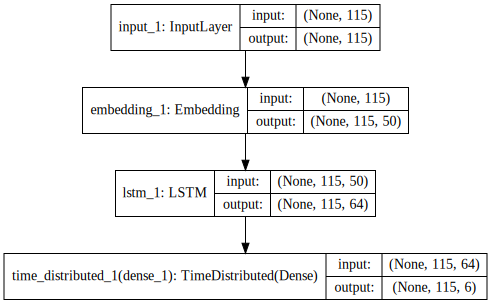

In [58]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model_in_notebook(model)

In [59]:
model.fit(
    int_sequences, tag_seqs, 
    validation_split=0.2, 
    epochs=10, 
    batch_size=128
)

Train on 11089 samples, validate on 2773 samples
Epoch 1/10
11089/11089 [==============================] - 12s 1ms/step - loss: 0.3689 - acc: 0.9647 - val_loss: 0.1316 - val_acc: 0.9760
Epoch 2/10
11089/11089 [==============================] - 11s 1ms/step - loss: 0.0982 - acc: 0.9790 - val_loss: 0.0721 - val_acc: 0.9831
Epoch 3/10
11089/11089 [==============================] - 12s 1ms/step - loss: 0.0583 - acc: 0.9862 - val_loss: 0.0509 - val_acc: 0.9871
Epoch 4/10
11089/11089 [==============================] - 12s 1ms/step - loss: 0.0430 - acc: 0.9892 - val_loss: 0.0403 - val_acc: 0.9891
Epoch 5/10
11089/11089 [==============================] - 11s 993us/step - loss: 0.0356 - acc: 0.9906 - val_loss: 0.0356 - val_acc: 0.9903
Epoch 6/10
11089/11089 [==============================] - 12s 1ms/step - loss: 0.0314 - acc: 0.9915 - val_loss: 0.0319 - val_acc: 0.9910
Epoch 7/10
11089/11089 [==============================] - 11s 962us/step - loss: 0.0291 - acc: 0.9921 - val_loss: 0.0298 - val_

In [60]:
#sentence = 'I live in Brussels , BG.'.split()
sentence = 'Today people will vote for president in Fooland , Janet said .'.split()

# TODO:
# 1. turn sentence (list of str) into an integer sequence
# 2. Use the model, call `predict` on the integer sequence
# 3. create a list of predicted labels for each word called `predicted_labels`
# 4. remove the padding from predicted_labels

sent_int = []
for w in sentence:
    if w.lower() in word_to_num.keys():
        sent_int.append(word_to_num[w.lower()])
    else:
        sent_int.append(0)  # Make it zero if unmapped
        
sent_int = pad_sequences([sent_int], MAX_SEQ_LEN)
preds = model.predict(sent_int)
preds = np.argmax(preds[0], axis=1)

predicted_labels = []
for t in preds:
    if t > 0:
        predicted_labels.append(NUM_TO_TAG[t])
    
for word, lab in zip(sentence, predicted_labels):
    print('{}: {}'.format(word, lab))

Today: O
people: O
will: O
vote: O
for: O
president: O
in: O
Fooland: O
,: O
Janet: PER
said: O
.: O
